CS4001/4042 Assignment 1
---
Part B, Q1 (15 marks)
---

Real world datasets often have a mix of numeric and categorical features – this dataset is one example. To build models on such data, categorical features have to be encoded or embedded.

PyTorch Tabular is a library that makes it very convenient to build neural networks for tabular data. It is built on top of PyTorch Lightning, which abstracts away boilerplate model training code and makes it easy to integrate other tools, e.g. TensorBoard for experiment tracking.

For questions B1 and B2, the following features should be used:   
- **Numeric / Continuous** features: dist_to_nearest_stn, dist_to_dhoby, degree_centrality, eigenvector_centrality, remaining_lease_years, floor_area_sqm
- **Categorical** features: month, town, flat_model_type, storey_range



---



In [ ]:
SEED = 42

import os
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig
from pytorch_tabular.config import (DataConfig, OptimizerConfig, TrainerConfig)

from sklearn.metrics import r2_score, mean_squared_error

random.seed(SEED)
np.random.seed(SEED)
warnings.filterwarnings('ignore')
os.environ['TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD'] = '1' # https://github.com/suno-ai/bark/issues/626

continuous_features = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
categorical_features = ['month', 'town', 'flat_model_type', 'storey_range']

> Divide the dataset (‘hdb_price_prediction.csv’) into train and test sets by using entries from year 2020 and before as training data, and year 2021 as test data (validation set is not required).
**Do not** use data from year 2022 and year 2023.



In [2]:
df = pd.read_csv('hdb_price_prediction.csv')
train_df = df[df['year'] <= 2020].copy()
test_df = df[df['year'] == 2021].copy()

> Refer to the documentation of **PyTorch Tabular** and perform the following tasks: https://pytorch-tabular.readthedocs.io/en/latest/#usage
- Use **[DataConfig](https://pytorch-tabular.readthedocs.io/en/latest/data/)** to define the target variable, as well as the names of the continuous and categorical variables.
- Use **[TrainerConfig](https://pytorch-tabular.readthedocs.io/en/latest/training/)** to automatically tune the learning rate. Set batch_size to be 1024 and set max_epoch as 50.
- Use **[CategoryEmbeddingModelConfig](https://pytorch-tabular.readthedocs.io/en/latest/models/#category-embedding-model)** to create a feedforward neural network with 1 hidden layer containing 50 neurons.
- Use **[OptimizerConfig](https://pytorch-tabular.readthedocs.io/en/latest/optimizer/)** to choose Adam optimiser. There is no need to set the learning rate (since it will be tuned automatically) nor scheduler.
- Use **[TabularModel](https://pytorch-tabular.readthedocs.io/en/latest/tabular_model/)** to initialise the model and put all the configs together.

In [3]:
data_config = DataConfig(
  target=['resale_price'],
  continuous_cols=continuous_features,
  categorical_cols=categorical_features,
)

trainer_config = TrainerConfig(
  auto_lr_find=True,
  batch_size=1024,
  max_epochs=50,
)

model_config = CategoryEmbeddingModelConfig(task="regression", layers="50")
optimizer_config = OptimizerConfig()

tabular_model = TabularModel(
  data_config=data_config,
  model_config=model_config,
  optimizer_config=optimizer_config,
  trainer_config=trainer_config,
)

2025-02-27 21:11:01,713 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

In [4]:
%%capture
tabular_model.fit(train=train_df, validation=test_df) #type: ignore
result = tabular_model.evaluate(test_df)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.5754399373371567
Restoring states from the checkpoint path at c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.lr_find_155a7e15-8347-417c-8a16-8b4b4aa3eb4b.ckpt
Restored all states from the checkpoint at c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.lr_find_155a7e15-8347-417c-8a16-8b4b4aa3eb4b.ckpt


> Report the test RMSE error and the test R2 value that you obtained.



In [5]:
%%capture
predictions = tabular_model.predict(test_df)
rmse = np.sqrt(mean_squared_error(test_df["resale_price"], predictions))
r2 = r2_score(test_df["resale_price"], predictions)

In [6]:
print("Test RMSE:", rmse) #type: ignore
print("Test R2:", r2) #type: ignore

Test RMSE: 63529.12561519079
Test R2: 0.8474233754422245


> Print out the corresponding rows in the dataframe for the top 25 test samples with the largest errors. 



In [7]:
errors_df = test_df.copy()
errors_df["predicted_resale_price"] = predictions #type: ignore
errors_df["error"] = abs(errors_df["resale_price"] - errors_df["predicted_resale_price"])
print(errors_df.sort_values("error", ascending=False).head(25))

        month  year          town                full_address    nearest_stn  \
92405      11  2021   BUKIT MERAH            46 SENG POH ROAD    Tiong Bahru   
112128     12  2021      TAMPINES      156 TAMPINES STREET 12       Tampines   
90251       4  2021        BISHAN         454 SIN MING AVENUE      Marymount   
90957       6  2021   BUKIT BATOK  288A BUKIT BATOK STREET 25    Bukit Batok   
91871       6  2021   BUKIT MERAH         17 TIONG BAHRU ROAD    Tiong Bahru   
90608      12  2021        BISHAN       273B BISHAN STREET 24         Bishan   
92504      12  2021   BUKIT MERAH            49 KIM PONG ROAD    Tiong Bahru   
92299      10  2021   BUKIT MERAH         36 MOH GUAN TERRACE    Tiong Bahru   
92442      11  2021   BUKIT MERAH          127D KIM TIAN ROAD    Tiong Bahru   
98379      12  2021       HOUGANG        615 HOUGANG AVENUE 8        Hougang   
91694       4  2021   BUKIT MERAH          35 LIM LIAK STREET    Tiong Bahru   
92340      10  2021   BUKIT MERAH       

Part B, Q2 (10 marks)
---
In Question B1, we used the Category Embedding model. This creates a feedforward neural network in which the categorical features get learnable embeddings. In this question, we will make use of a library called Pytorch-WideDeep. This library makes it easy to work with multimodal deep-learning problems combining images, text, and tables. We will just be utilizing the deeptabular component of this library through the TabMlp network.

In [8]:
import pandas as pd
from pytorch_widedeep import Trainer
from pytorch_widedeep.metrics import R2Score
from pytorch_widedeep.models import TabMlp, WideDeep
from pytorch_widedeep.preprocessing import TabPreprocessor

>Divide the dataset (‘hdb_price_prediction.csv’) into train and test sets by using entries from the year 2020 and before as training data, and entries from 2021 and after as the test data（validation set is not required here).

In [9]:
df = pd.read_csv('hdb_price_prediction.csv')
train_df = df[df['year'] <= 2020].copy()
test_df = df[df['year'] >= 2021].copy()

>Refer to the documentation of Pytorch-WideDeep and perform the following tasks:
https://pytorch-widedeep.readthedocs.io/en/latest/index.html
* Use [**TabPreprocessor**](https://pytorch-widedeep.readthedocs.io/en/latest/examples/01_preprocessors_and_utils.html#2-tabpreprocessor) to create the deeptabular component using the continuous
features and the categorical features. Use this component to transform the training dataset.
* Create the [**TabMlp**](https://pytorch-widedeep.readthedocs.io/en/latest/pytorch-widedeep/model_components.html#pytorch_widedeep.models.tabular.mlp.tab_mlp.TabMlp) model with 2 hidden layers in the MLP, with 200 and 100 neurons respectively.
* Create a [**Trainer**](https://pytorch-widedeep.readthedocs.io/en/latest/pytorch-widedeep/trainer.html#pytorch_widedeep.training.Trainer) for the training of the created TabMlp model with the root mean squared error (RMSE) cost function. Train the model for 60 epochs using this trainer, keeping a batch size of 64. (Note: set the *num_workers* parameter to 0.)

In [10]:
tab_preprocessor = TabPreprocessor(
  cat_embed_cols=categorical_features,
  continuous_cols=continuous_features,
)
tab_x_train = tab_preprocessor.fit_transform(train_df)

tab_mlp = TabMlp(
  mlp_hidden_dims=[200, 100],
  column_idx=tab_preprocessor.column_idx,
  cat_embed_input=tab_preprocessor.cat_embed_input,
  continuous_cols=continuous_features,
)
wide_deep = WideDeep(wide=None, deeptabular=tab_mlp)

trainer = Trainer(
  model=wide_deep,
  objective="rmse",
  num_workers=0
)

trainer.fit(
  X_tab=tab_x_train,
  target=train_df["resale_price"].values,
  n_epochs=60,
  batch_size=64,
)

c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.venv\Lib\site-packages\pytorch_widedeep\preprocessing\tab_preprocessor.py:364: UserWarning: Continuous columns will not be normalised
  warnings.warn("Continuous columns will not be normalised")
epoch 60: 100%|██████████| 1366/1366 [00:28<00:00, 48.06it/s, loss=4.61e+4]


>Report the test RMSE and the test R2 value that you obtained.

In [11]:
tab_x_test = tab_preprocessor.transform(test_df)
predictions = trainer.predict(X_tab=tab_x_test)

rmse = np.sqrt(mean_squared_error(test_df["resale_price"], predictions))
r2 = r2_score(test_df["resale_price"], predictions)

print("Test RMSE:", rmse)
print("Test R2:", r2)

predict: 100%|██████████| 1128/1128 [00:11<00:00, 95.40it/s]


Test RMSE: 100229.64896670372
Test R2: 0.6490130665888925


Part B, Q3 (10 marks)
---
Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.




---



In [48]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import optimizer
from typing import Tuple, Union, List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation, DeepLift

NUM_EPOCHS = 200
BATCH_SIZE = 50

> First, use the train set (year 2020 and before) and test set (year 2021) following the splits in Question B1 (validation set is not required here). To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Standardise the features via **StandardScaler** (fit to training set, then transform all).

In [49]:
class HDBDataset(Dataset):
  def __init__(self, x: np.ndarray, y: np.ndarray) -> None:
    self.x = torch.from_numpy(x).float()
    self.y = torch.from_numpy(y).float()
  
  def __len__(self) -> int:
    return len(self.x)
  
  def __getitem__(self, index: int) -> Tuple[int, int]:
    return self.x[index], self.y[index]

In [52]:
df = pd.read_csv('hdb_price_prediction.csv')
df = df[continuous_features + ['resale_price', 'year']]

train_df = df[df['year'] <= 2020].copy()
test_df = df[df['year'] == 2021].copy()

train_df = train_df.drop(columns=['year'])
test_df = test_df.drop(columns=['year'])

train_x_df = train_df[continuous_features]
train_y_df = train_df['resale_price']

test_x = test_df[continuous_features]
test_y = test_df['resale_price']

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x_df)
test_x = scaler.transform(test_x)

train_dataset = HDBDataset(train_x, train_y_df.values)
test_dataset = HDBDataset(test_x, test_y.values)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Input x Gradients, Integrated Gradients, DeepLift, GradientSHAP, Feature Ablation. To avoid long running time, you can limit the analysis to the first 1000 samples in test set.

In [53]:
class FeedForward(nn.Module):
  def __init__(self, in_channels: int = 6, hidden_channels: int = 5, out_channels: int = 1) -> None:
    super().__init__()
    self.linear_1 = nn.Linear(in_channels, hidden_channels)
    self.act_fn_1 = nn.ReLU()
    self.linear_2 = nn.Linear(hidden_channels, hidden_channels)
    self.act_fn_2 = nn.ReLU()
    self.linear_3 = nn.Linear(hidden_channels, out_channels)


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.linear_1(x)
    x = self.act_fn_1(x)

    x = self.linear_2(x)
    x = self.act_fn_2(x)

    x = self.linear_3(x)
    return x  
  
model = FeedForward()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss(reduction="sum")

# Train this bitch
for epoch in range(NUM_EPOCHS):
  running_loss = 0.0
  for x, y in train_dataloader:
    predictions = model(x)
    loss = loss_fn(predictions, y)

    optimizer.zero_grad()
    loss.backward()

    running_loss += loss.item()
    optimizer.step()
  if epoch % 20 == 0:
    print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, NUM_EPOCHS, running_loss))

c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1]/[200] running accumulative loss across all batches: 957746782580768768.000
Epoch [21]/[200] running accumulative loss across all batches: 108946965614559232.000
Epoch [41]/[200] running accumulative loss across all batches: 104369693937106944.000
Epoch [61]/[200] running accumulative loss across all batches: 104199866657275904.000
Epoch [81]/[200] running accumulative loss across all batches: 104146903758798848.000
Epoch [101]/[200] running accumulative loss across all batches: 104103375034908672.000
Epoch [121]/[200] running accumulative loss across all batches: 104054866750472192.000
Epoch [141]/[200] running accumulative loss across all batches: 104002410274357248.000
Epoch [161]/[200] running accumulative loss across all batches: 103959591794507776.000
Epoch [181]/[200] running accumulative loss across all batches: 103916591107801088.000


In [54]:
model.eval()
outputs = model(torch.from_numpy(test_x).float())
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), test_y))
print(err)

174493.8596923267


c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.venv\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.venv\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


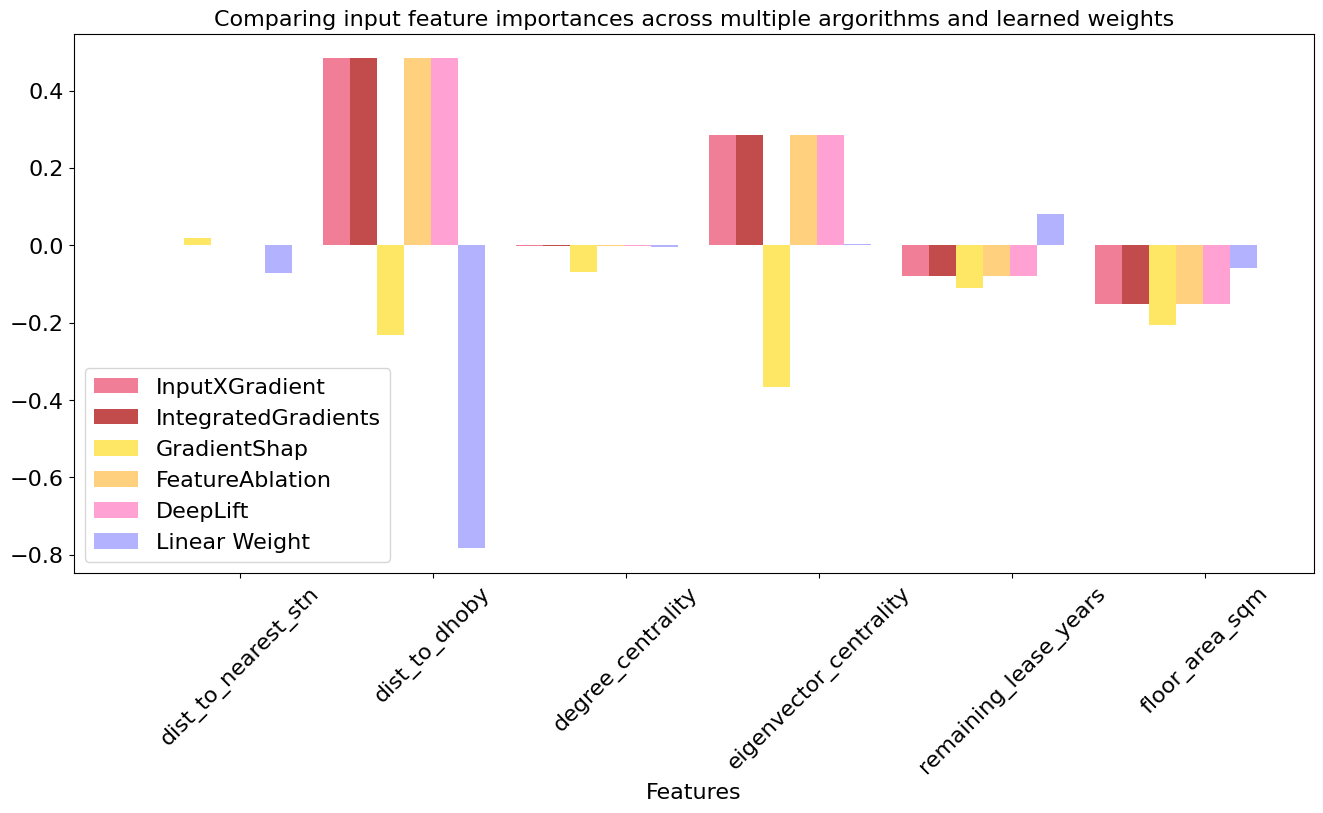

In [59]:
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)
dl = DeepLift(model)

ixg_attr_test = ixg.attribute(torch.from_numpy(test_x[:1000]).float())
ig_attr_test = ig.attribute(torch.from_numpy(test_x[:1000]).float(), n_steps=50)
gs_attr_test = gs.attribute(torch.from_numpy(test_x[:1000]).float(), torch.from_numpy(train_x).float())
fa_attr_test = fa.attribute(torch.from_numpy(test_x[:1000]).float())
dl_attr_test = dl.attribute(torch.from_numpy(test_x[:1000]).float())

features = train_x_df.columns.values
x_axis_data = np.arange(test_x.shape[1])
x_axis_data_labels = list(map(lambda index: features[index], x_axis_data))

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

linear_weight = model.linear_1.weight[0].detach().numpy()
y_axis_lin_weight = linear_weight / np.linalg.norm(linear_weight, ord=1)

width = 0.14
legends = ['InputXGradient', 'IntegratedGradients', 'GradientShap', 'FeatureAblation', 'DeepLift', 'Linear Weight']

plt.figure(figsize=(16, 7))

ax = plt.subplot()
ax.set_title("Comparing input feature importances across multiple argorithms and learned weights")
ax.set_xlabel("Features")

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)
plt.rc('axes', titlesize=FONT_SIZE)
plt.rc('axes', labelsize=FONT_SIZE)
plt.rc('legend', fontsize=FONT_SIZE)

ax.bar(x_axis_data, ixg_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, gs_attr_test_norm_sum, width, align='center', alpha=0.6, color='#FFD700')
ax.bar(x_axis_data + 3 * width, fa_attr_test_norm_sum, width, align='center', alpha=0.5, color='#FFA500')
ax.bar(x_axis_data + 4 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.4, color='#FF1493')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=0.3, color='#0000FF')

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels, rotation=45)

plt.legend(legends)
plt.show()

> Read the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum to build up your understanding of the difference of various explainability algorithms. Based on your plot, identify the three most important features for regression. Explain how each of these features influences the regression outcome.


<div style="color:lightgreen">
The 3 most important features are <bold style="font-weight:bold">dist_to_dhoby, eigenvector_centrality and floor_area_sqm</bold>.
When <i>dist_to_dhoby</i> or <i>eigenvector_centrality</i> go up, then <i>resale_price</i> goes up.
When <i>floor_area_sqm</i> goes down, then <i>resale_price</i> goes down as well.
</div>

Part B, Q4 (10 marks)
---

Model degradation is a common issue faced when deploying machine learning models (including neural networks) in the real world. New data points could exhibit a different pattern from older data points due to factors such as changes in government policy or market sentiments. For instance, housing prices in Singapore have been increasing and the Singapore government has introduced 3 rounds of cooling measures over the past years (16 December 2021, 30 September 2022, 27 April 2023).

In such situations, the distribution of the new data points could differ from the original data distribution which the models were trained on. Recall that machine learning models often work with the assumption that the test distribution should be similar to train distribution. When this assumption is violated, model performance will be adversely impacted.  In the last part of this assignment, we will investigate to what extent model degradation has occurred.




---



> Evaluate your model from B1 on data from year 2022 and report the test R2.

In [ ]:
new_test_data = pd.read_csv('hdb_price_prediction.csv')
new_test_data = new_test_data[continuous_features + categorical_features + ['resale_price', 'year']]
new_test_data = new_test_data[new_test_data['year'] == 2022].copy()
new_test_data = new_test_data.drop(columns=['year'])
newer_test_data = new_test_data.drop(columns=['resale_price'])

predictions = tabular_model.predict(newer_test_data)
rmse = np.sqrt(mean_squared_error(new_test_data["resale_price"], predictions))
r2 = r2_score(new_test_data["resale_price"], predictions)

print("Test RMSE:", rmse)
print("Test R2:", r2)

c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.venv\Lib\site-packages\pytorch_tabular\tabular_model.py:1466: DeprecationWarning: `include_input_features` will be deprecated in the next release. Please add index columns to the test dataframe if you want to retain some features like the key or id
  warnings.warn(
c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.venv\Lib\site-packages\pytorch_tabular\categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fi

Test RMSE: 114670.68872706252
Test R2: 0.5463953994310161


> Evaluate your model from B1 on data from year 2023 and report the test R2.

In [20]:
new_test_data = pd.read_csv('hdb_price_prediction.csv')
new_test_data = new_test_data[continuous_features + categorical_features + ['resale_price', 'year']]
new_test_data = new_test_data[new_test_data['year'] == 2023].copy()
new_test_data = new_test_data.drop(columns=['year'])
newer_test_data = new_test_data.drop(columns=['resale_price'])

predictions = tabular_model.predict(newer_test_data)
rmse = np.sqrt(mean_squared_error(new_test_data["resale_price"], predictions))
r2 = r2_score(new_test_data["resale_price"], predictions)

print("Test RMSE:", rmse)
print("Test R2:", r2)

c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.venv\Lib\site-packages\pytorch_tabular\tabular_model.py:1466: DeprecationWarning: `include_input_features` will be deprecated in the next release. Please add index columns to the test dataframe if you want to retain some features like the key or id
  warnings.warn(
c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.venv\Lib\site-packages\pytorch_tabular\categorical_encoders.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_encoded[col].fi

Test RMSE: 146511.45234283112
Test R2: 0.27188335018287413


> Did model degradation occur for the deep learning model?

<div style="color:lightgreen">
<bold style="font-weight:bold">Yes the model shows signs of degredation.</bold>
<p>It's R2 value went down signalling that it's predictions haven't been as accurate compared to when testing on data from 2021.</p>
</div>

Model degradation could be caused by [various data distribution shifts](https://huyenchip.com/2022/02/07/data-distribution-shifts-and-monitoring.html#data-shift-types): covariate shift (features), label shift and/or concept drift (altered relationship between features and labels).
There are various conflicting terminologies in the [literature](https://www.sciencedirect.com/science/article/pii/S0950705122002854#tbl1). Let’s stick to this reference for this assignment.

> Using the **Alibi Detect** library, apply the **TabularDrift** function with the training data (year 2020 and before) used as the reference and **detect which features have drifted** in the 2023 test dataset. Before running the statistical tests, ensure you **sample 1000 data points** each from the train and test data. Do not use the whole train/test data. (Hint: use this example as a guide https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_chi2ks_adult.html)


In [40]:
import alibi
import matplotlib.pyplot as plt
import numpy as np

from alibi_detect.cd import TabularDrift
from alibi_detect.saving import save_detector, load_detector

continuous_features = ['dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'remaining_lease_years', 'floor_area_sqm']
categorical_features = ['month', 'town', 'flat_model_type', 'storey_range']

n_ref = 1000
n_test = 1000

# Manipulate data
data_df = pd.read_csv('hdb_price_prediction.csv')
data_df = data_df[continuous_features + categorical_features + ['year', 'resale_price']]
train_df = data_df[data_df['year'] <= 2020].copy()
test_df = data_df[data_df['year'] == 2023].copy()
train_df = train_df.drop(columns=['year'])
test_df = test_df.drop(columns=['year'])
train_df = train_df.sample(n=n_ref, random_state=42)
test_df = test_df.sample(n=n_test, random_state=42)
train_array = train_df.to_numpy()
test_array = test_df.to_numpy()

# Predict
categories_per_feature = {train_df.columns.get_loc(col): None for col in categorical_features}
cd = TabularDrift(x_ref=train_array, p_val=.05, categories_per_feature=categories_per_feature)
predictions = cd.predict(test_array, drift_type='feature')

# See what features are drifting
labels = ['No.', 'Yes.']
features = train_df.columns.values
for index in range(cd.n_features):
  feature = features[index]
  print(f'Is feature {feature} drifting? {labels[predictions["data"]["is_drift"][index]]}')

Is feature dist_to_nearest_stn drifting? Yes.
Is feature dist_to_dhoby drifting? No.
Is feature degree_centrality drifting? No.
Is feature eigenvector_centrality drifting? No.
Is feature remaining_lease_years drifting? Yes.
Is feature floor_area_sqm drifting? No.
Is feature month drifting? Yes.
Is feature town drifting? No.
Is feature flat_model_type drifting? No.
Is feature storey_range drifting? Yes.
Is feature resale_price drifting? Yes.


> Assuming that the flurry of housing measures have made an impact on the relationship between all the features and resale_price (i.e. P(Y|X) changes), which type of data distribution shift possibly led to model degradation?

<div style="color:lightgreen">
<bold style="font-weight:bold">Concept Shift</bold>
<p>Since the the housing measures affected the <i>relationship</i> between the features, the degredation is most probably due to concept shift.</p>
</div>

> From your analysis via TabularDrift, which features contribute to this shift?

<bold style="font-weight:bold;color:lightgreen">
  dist_to_nearest_stn, remaining_lease_years, month, storey_range, resale_price
</bold>

> Suggest 1 way to address model degradation and implement it, showing improved test R2 for year 2023.

<div style="color:lightgreen">One way to reduce model degredation is to retrain it with recently updated data.</div>

In [45]:
%%capture 
# Training model on 2021 <= data
df = pd.read_csv('hdb_price_prediction.csv')
train_df = df[df['year'] <= 2021].copy()
test_df = df[df['year'] == 2022].copy()

data_config = DataConfig(
  target=['resale_price'],
  continuous_cols=continuous_features,
  categorical_cols=categorical_features,
)

trainer_config = TrainerConfig(
  auto_lr_find=True,
  batch_size=1024,
  max_epochs=50,
)

model_config = CategoryEmbeddingModelConfig(task="regression", layers="50")
optimizer_config = OptimizerConfig()

tabular_model = TabularModel(
  data_config=data_config,
  model_config=model_config,
  optimizer_config=optimizer_config,
  trainer_config=trainer_config,
)

tabular_model.fit(train=train_df, validation=test_df)
result = tabular_model.evaluate(test_df)

predictions = tabular_model.predict(test_df)
rmse = np.sqrt(mean_squared_error(test_df["resale_price"], predictions))
r2 = r2_score(test_df["resale_price"], predictions)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.5754399373371567
Restoring states from the checkpoint path at c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.lr_find_ab628043-14bb-4e5d-a297-e1a71e83337d.ckpt
Restored all states from the checkpoint at c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.lr_find_ab628043-14bb-4e5d-a297-e1a71e83337d.ckpt


In [42]:
print("Test RMSE:", rmse) #type: ignore
print("Test R2:", r2) #type: ignore

Test RMSE: 102195.76911363042
Test R2: 0.639721420576722


<bold style="font-weight:bold;color:lightgreen">Improvement!</bold>

In [43]:
%%capture 
# Training model on 2022 <= data
df = pd.read_csv('hdb_price_prediction.csv')
train_df = df[df['year'] <= 2022].copy()
test_df = df[df['year'] == 2023].copy()

data_config = DataConfig(
  target=['resale_price'],
  continuous_cols=continuous_features,
  categorical_cols=categorical_features,
)

trainer_config = TrainerConfig(
  auto_lr_find=True,
  batch_size=1024,
  max_epochs=50,
)

model_config = CategoryEmbeddingModelConfig(task="regression", layers="50")
optimizer_config = OptimizerConfig()

tabular_model = TabularModel(
  data_config=data_config,
  model_config=model_config,
  optimizer_config=optimizer_config,
  trainer_config=trainer_config,
)

tabular_model.fit(train=train_df, validation=test_df)
result = tabular_model.evaluate(test_df)

predictions = tabular_model.predict(test_df)
rmse = np.sqrt(mean_squared_error(test_df["resale_price"], predictions))
r2 = r2_score(test_df["resale_price"], predictions)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.5754399373371567
Restoring states from the checkpoint path at c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.lr_find_7b4b6e80-6343-4252-8424-04127f61473b.ckpt
Restored all states from the checkpoint at c:\Users\Shun Jie\Documents\Github\hdb_price_regression_prediction\.lr_find_7b4b6e80-6343-4252-8424-04127f61473b.ckpt


In [44]:
print("Test RMSE:", rmse) #type: ignore
print("Test R2:", r2) #type: ignore

Test RMSE: 126884.63616679952
Test R2: 0.45389532717848124


<bold style="font-weight:bold;color:lightgreen">Improvement!</bold>